# **Forecast**

Autor: Sergio Diaz Paredes

Contacto: [Linkedin](https://www.linkedin.com/in/sergio-diaz-paredes/)

## Paquetes

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

## Data

In [ ]:
link = "https://raw.githubusercontent.com/SergioDP94/Talleres/refs/heads/main/Forecast/ventas_tech.csv"
data = pd.read_csv(link,parse_dates=['Fecha'])
data.head()

,Fecha,Producto,Medio_pago,Sucursal,Factura
0,2024-01-01,Laptops,Efectivo,Sucursal Sur,FAC000001
1,2024-01-01,Laptops,Tarjeta de Crédito,Sucursal Centro,FAC000002
2,2024-01-01,Laptops,Efectivo,Sucursal Norte,FAC000003
3,2024-01-01,Laptops,Efectivo,Sucursal Centro,FAC000004
4,2024-01-01,Laptops,Efectivo,Sucursal Norte,FAC000005


<Axes: xlabel='Fecha'>

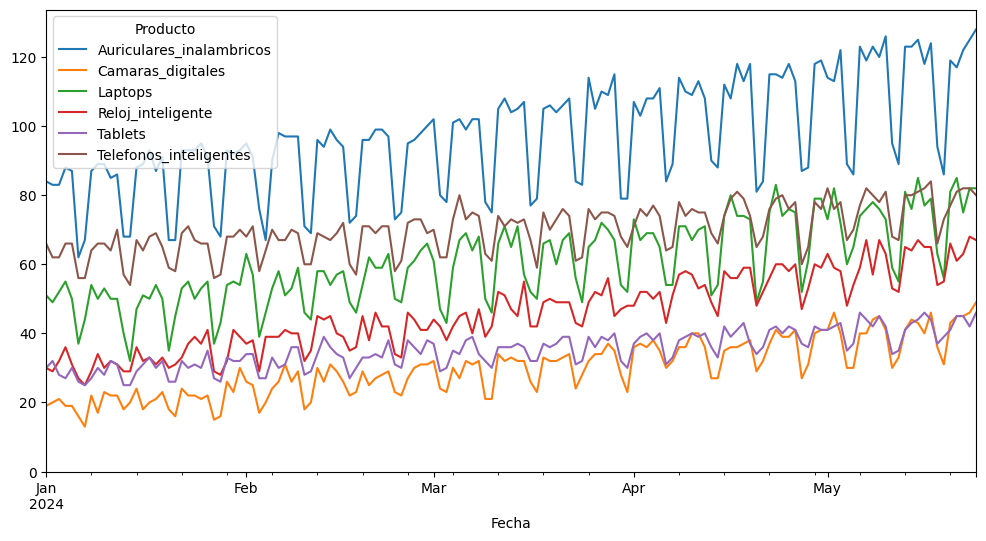

In [ ]:
tabla = data.pivot_table(index='Fecha',columns='Producto',values='Factura',aggfunc='count')
tabla.plot(ylim=(0),figsize=(12,6))

In [ ]:
serie = tabla['Laptops']
serie.tail()

,Laptops
Fecha,
2024-05-20,81
2024-05-21,85
2024-05-22,75
2024-05-23,82
2024-05-24,82


## Modelo Holt-Winters

In [ ]:
n_step = 28

In [ ]:
# Holt-Winters
holt_winters_model = ExponentialSmoothing(serie, trend='add', seasonal='add', seasonal_periods=7)
holt_winters_fit = holt_winters_model.fit()

# Predicción de 7 periodos con Holt-Winters
holt_winters_forecast = holt_winters_fit.forecast(steps=n_step)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


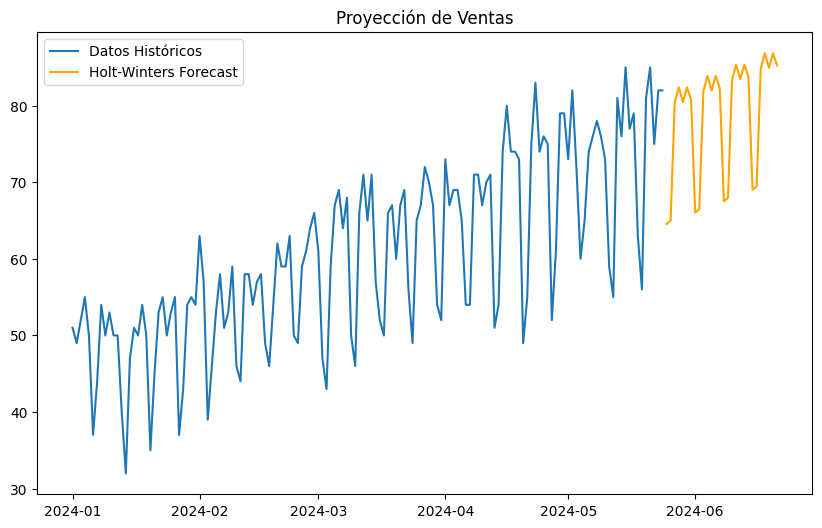

In [ ]:
# Visualización de los resultados
plt.figure(figsize=(10, 6))
plt.plot(serie, label='Datos Históricos')
plt.plot(holt_winters_forecast, label='Holt-Winters Forecast', color='orange')
plt.legend()
plt.title('Proyección de Ventas')
plt.show()

## Modelo Sarimax

In [ ]:
# SARIMA Model
sarima_model = SARIMAX(serie, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
sarima_fit = sarima_model.fit()

# Predicción con SARIMA
sarima_forecast = sarima_fit.forecast(steps=n_step)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


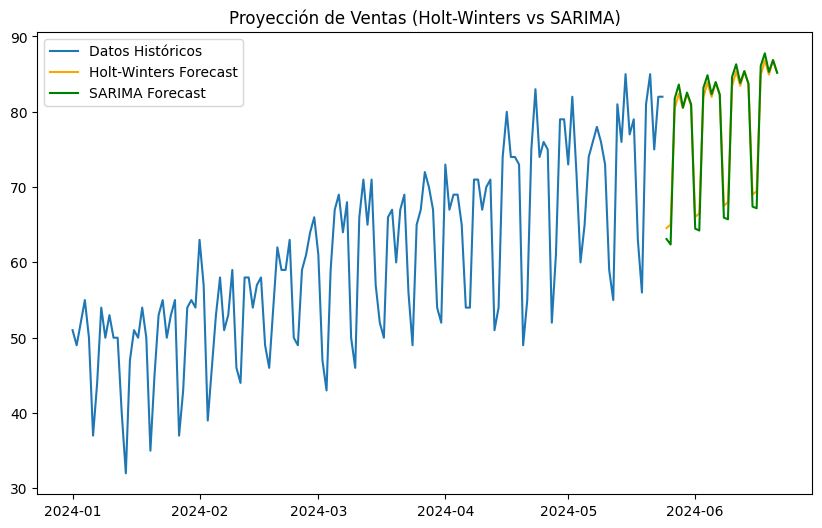

In [ ]:
# Visualización de los resultados
plt.figure(figsize=(10, 6))
plt.plot(serie.index, serie, label='Datos Históricos')
plt.plot(holt_winters_forecast, label='Holt-Winters Forecast', color='orange')
plt.plot(sarima_forecast, label='SARIMA Forecast', color='green')
plt.legend()
plt.title('Proyección de Ventas (Holt-Winters vs SARIMA)')
plt.show()

## Prophet

In [ ]:
df = serie.reset_index()
df.columns = ['ds', 'y']  # 'ds' es la fecha y 'y' es el valor
df.head()

,ds,y
0,2024-01-01,51
1,2024-01-02,49
2,2024-01-03,52
3,2024-01-04,55
4,2024-01-05,50


In [ ]:
# Crear y ajustar el modelo
prophet_model = Prophet(
    daily_seasonality=False,  # Activar estacionalidad diaria si es necesario
    seasonality_mode='multiplicative',  # Estacionalidad multiplicativa (si se ajusta a los datos)
    yearly_seasonality=False,  # Desactivar la estacionalidad anual si no la necesitas
    weekly_seasonality=True  # Desactivar la estacionalidad semanal si no es relevante
)
prophet_model.fit(df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp96d_nv25/76oshndp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp96d_nv25/ifdbe626.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50326', 'data', 'file=/tmp/tmp96d_nv25/76oshndp.json', 'init=/tmp/tmp96d_nv25/ifdbe626.json', 'output', 'file=/tmp/tmp96d_nv25/prophet_modelaltzbuyx/prophet_model-20250110171500.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:15:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Hacer la predicción para 12 periodos
future = prophet_model.make_future_dataframe(periods=n_step, freq='D')

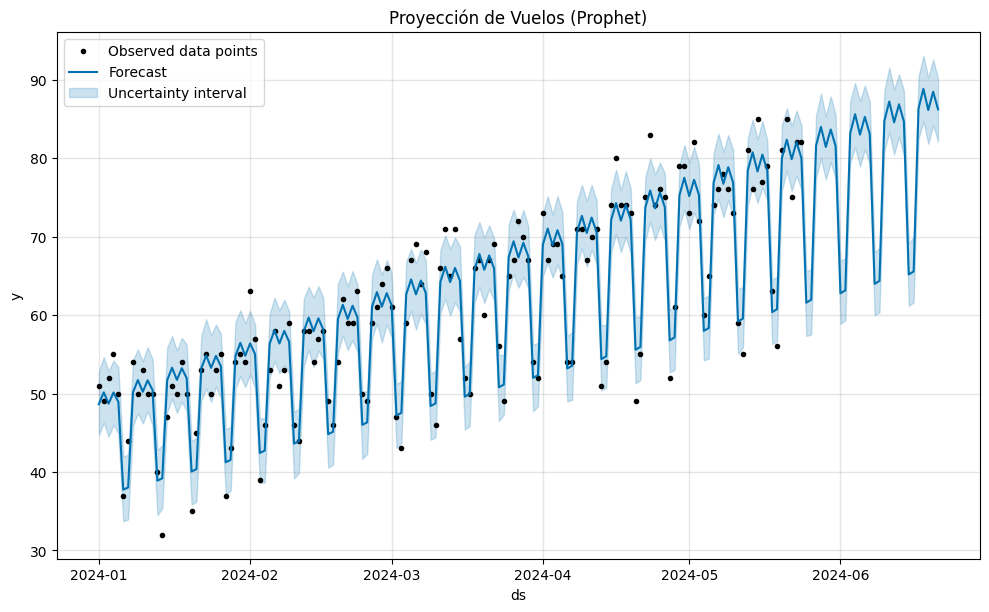

In [ ]:
# Realizar la predicción
forecast = prophet_model.predict(future)

prophet_model.plot(forecast)
plt.legend()
plt.title('Proyección de Vuelos (Prophet)')
plt.show()

In [ ]:
prohet_forecast = pd.Series(forecast.yhat[-n_step:].to_list(),index=sarima_forecast.index)

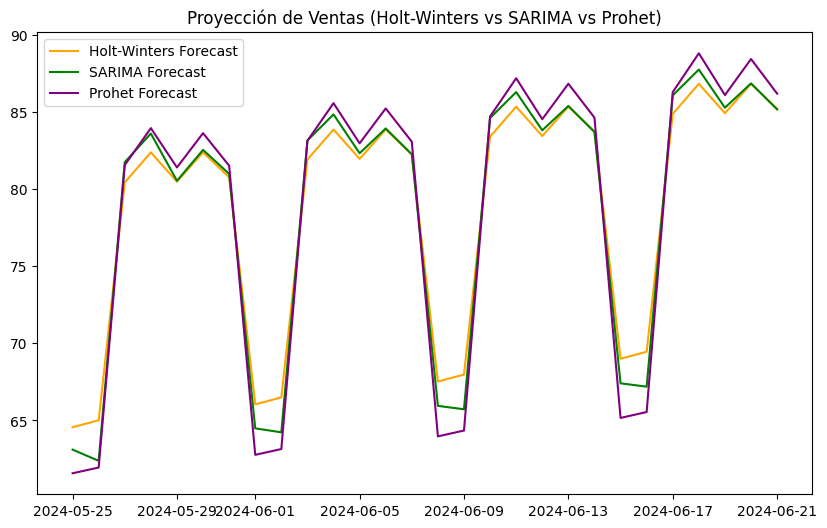

In [ ]:
# Visualización de los resultados
plt.figure(figsize=(10, 6))
plt.plot(holt_winters_forecast, label='Holt-Winters Forecast', color='orange')
plt.plot(sarima_forecast, label='SARIMA Forecast', color='green')
plt.plot(prohet_forecast, label='Prohet Forecast', color='purple')

plt.legend()
plt.title('Proyección de Ventas (Holt-Winters vs SARIMA vs Prohet)')
plt.show()

## Automatizacion

In [ ]:
def get_forecast(serie,n_step,type='hw'):
  if type == 'hw':
    holt_winters_model = ExponentialSmoothing(serie, trend='add', seasonal='add', seasonal_periods=7)
    holt_winters_fit = holt_winters_model.fit()
    holt_winters_forecast = holt_winters_fit.forecast(steps=n_step)
    return holt_winters_forecast
  elif type == 'sarima':
    sarima_model = SARIMAX(serie, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
    sarima_fit = sarima_model.fit()
    sarima_forecast = sarima_fit.forecast(steps=n_step)
    return sarima_forecast
  elif type == 'prophet':
    df = serie.reset_index()
    df.columns = ['ds', 'y']
    prophet_model = Prophet(
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    yearly_seasonality=False,
    weekly_seasonality=True)
    prophet_model.fit(df)
    future = prophet_model.make_future_dataframe(periods=n_step, freq='D')
    forecast = prophet_model.predict(future)
    index = pd.date_range(serie.index[-1], periods=(n_step + 1), freq='D')[1:]
    prohet_forecast = pd.Series(forecast.yhat[-n_step:].to_list(),index=index)
    return prohet_forecast

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<Axes: >

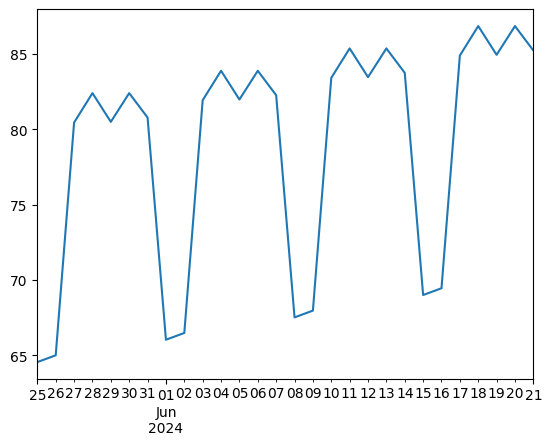

In [ ]:
get_forecast(serie,n_step,type='hw').plot()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<Axes: >

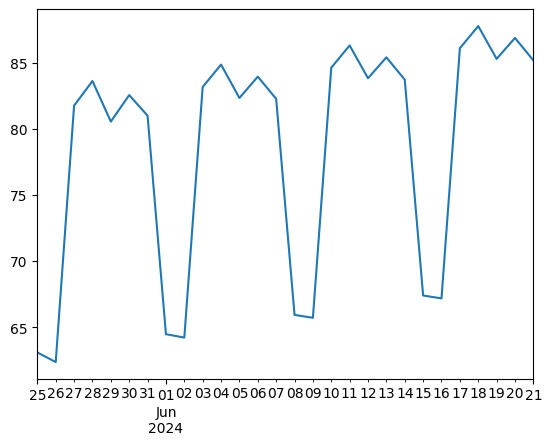

In [ ]:
get_forecast(serie,n_step,type='sarima').plot()

DEBUG:cmdstanpy:input tempfile: /tmp/tmp96d_nv25/4l4nftly.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp96d_nv25/tnp3ttji.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=616', 'data', 'file=/tmp/tmp96d_nv25/4l4nftly.json', 'init=/tmp/tmp96d_nv25/tnp3ttji.json', 'output', 'file=/tmp/tmp96d_nv25/prophet_modelbp8nit4c/prophet_model-20250110171509.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:15:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<Axes: >

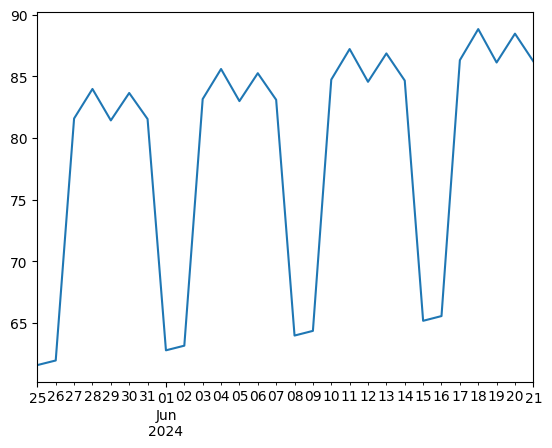

In [ ]:
get_forecast(serie,n_step,type='prophet').plot()

In [ ]:
get_forecast(serie,n_step,type='prophet').sum()

DEBUG:cmdstanpy:input tempfile: /tmp/tmp96d_nv25/dok5ymyo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp96d_nv25/6hwyzcu4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73859', 'data', 'file=/tmp/tmp96d_nv25/dok5ymyo.json', 'init=/tmp/tmp96d_nv25/6hwyzcu4.json', 'output', 'file=/tmp/tmp96d_nv25/prophet_modelc52mmpx7/prophet_model-20250110171510.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:15:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


2204.562350863345